In [4]:
import numpy as np
import pandas as pd
import scipy as sp
import pathlib

import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx

import navis 
import navis.interfaces.neuprint as neu
import neuprint as neu_orig
import NeuromodPlasticity as nmp 


plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EL_connectomics')
figfolder.mkdir(parents=True, exist_ok=True)

In [6]:
c = nmp.connectomics.npt_client()

In [7]:
# get body IDs for all EL PEG, EPG, PENa, PENb
pre_query = neu.NeuronCriteria(type=['EL', 'EPG', 'PEG', 'PEN_a.*', 'PEN_b.*'], outputRois=['EB'])

# get body IDs for all ER neurons
post_query = neu.NeuronCriteria(type=['ER1.*', 'ER2.*', 'ER3.*', 'ER4.*'], inputRois=['EB'])

In [8]:
# get connnectivity matrix
neuron_df, conn_df = neu.fetch_adjacencies(pre_query, post_query, rois=['EB'],properties=['type', 'instance', 'bodyID'],
                                       min_roi_weight=3)
conn_df = neu.merge_neuron_properties(neuron_df, conn_df, ['type'])

all_EB_presynapses = neu.fetch_synapses(conn_df['bodyId_pre'].unique(), neu.SynapseCriteria(rois='EB', type='pre', primary_only=True))
all_EB_postsynapses = neu.fetch_synapses(conn_df['bodyId_post'].unique(), neu.SynapseCriteria(rois='EB', type='post', primary_only=True))


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [9]:
# convert connecticity to "relative weight"
relative_weights, pcnt_output = [], []
for i, row in conn_df.iterrows():
#     # fetch synapses in EB
    n_postsynapses = all_EB_postsynapses[all_EB_postsynapses['bodyId'] == row['bodyId_post']].shape[0]
    n_post_neurons = (neuron_df['type']==row['type_post']).sum()
    relative_weights.append(row['weight']/float(n_postsynapses)/float(n_post_neurons))

    n_presynapses = all_EB_presynapses[all_EB_presynapses['bodyId'] == row['bodyId_pre']].shape[0]
    n_pre_neurons = (neuron_df['type']==row['type_pre']).sum()
    pcnt_output.append(row['weight']/float(n_presynapses)/float(n_pre_neurons))
conn_df['relative_weight'] = relative_weights
conn_df['pcnt_output'] = pcnt_output


In [10]:
from matplotlib.gridspec import GridSpec

def plot_er_inputs_with_marginal(conn_df, weight_col='relative_weight'):
    """
    Plot a heatmap of the connections from EPG, PEG, PEN_a, PEN_b, EL, ExR2 to ER neurons with a marginal plot showing the mean weight for each pre-synaptic neuron type.
    The heatmap shows the connection weights, and the marginal plot shows the mean weight for each pre-synaptic neuron type.
    Parameters
    ----------
    conn_df : pandas.DataFrame
        DataFrame containing the connection data with columns 'bodyId_post', 'type_post', and 'weight'.
    """
    # create a figure with gridspec
    fig = plt.figure(figsize=(12, 2))
    gs = GridSpec(1, 6, figure=fig)
    heatmap_ax = fig.add_subplot(gs[0, 0:4])  # heatmap in the first three columns
    marginal_ax = fig.add_subplot(gs[0, 4], sharey=heatmap_ax)  # marginal plot in the last column
    cbar_ax = fig.add_subplot(gs[0, 5])  # colorbar in the last column
    # plot the heatmap   
    conn_matrix_df = neu.connection_table_to_matrix(conn_df, weight_col=weight_col, sort_by='type', group_cols='type')
    conn_matrix_df.loc['PEG']=0
    conn_matrix_df.reindex(["EPG", "PEG", "PEN_a(PEN1)", "PEN_b(PEN2)", "EL"])
    g = sns.heatmap(conn_matrix_df.loc[["EPG", "PEG", "PEN_a(PEN1)", "PEN_b(PEN2)", "EL"]], ax=heatmap_ax, cmap='Blues', annot=False, cbar_kws={'label': 'Weight'},
                    cbar_ax=cbar_ax)


    mu = conn_matrix_df.mean(axis=1)
    # mu['PEG']=0
    mu = mu.reindex(["EPG", "PEG", "PEN_a(PEN1)", "PEN_b(PEN2)", "EL"])
    # print(mu)
    mu = mu.to_frame(name='mean_weight')

    marginal_ax.barh(np.arange(len(mu.index))+.5, mu['mean_weight'], color=plt.cm.Blues(.7))
    heatmap_ax.set_yticks( np.arange(len(mu.index))+.5, ["EPG", "PEG", "PEN_a(PEN1)", "PEN_b(PEN2)", "EL"])
    heatmap_ax.set_ylim(len(mu.index))  # Adjust y-limits to match the heatmap
    marginal_ax.set_ylabel('')
    marginal_ax.spines['right'].set_visible(False)
    marginal_ax.spines['top'].set_visible(False)
    # fig.tight_layout()
    return fig, (heatmap_ax, marginal_ax, cbar_ax)



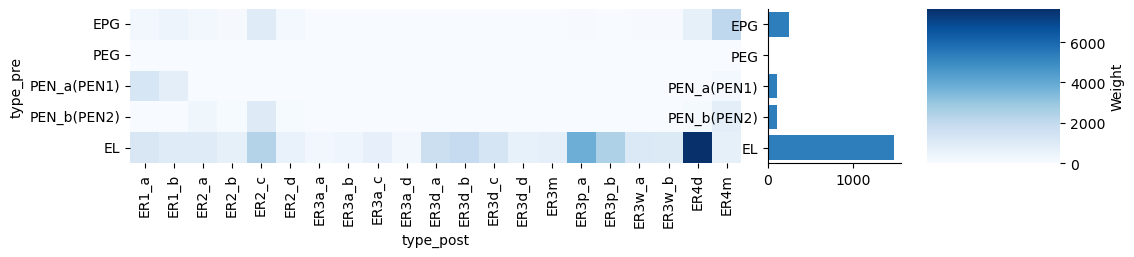

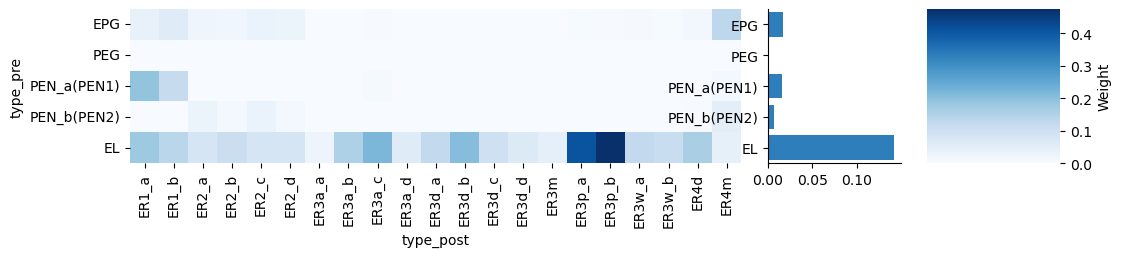

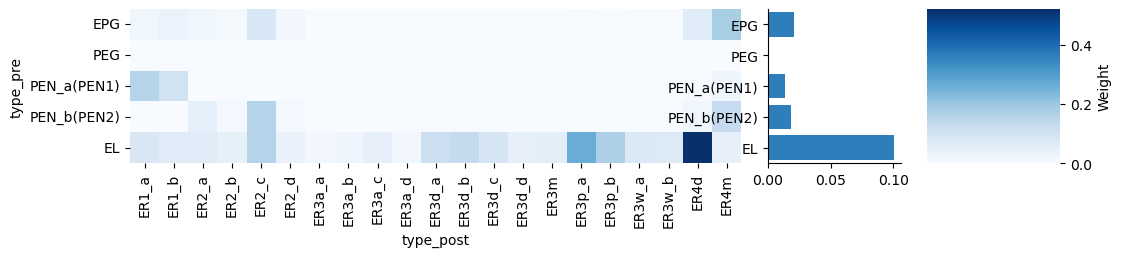

In [11]:
fig, (heatmap_ax, marginal_ax, cbar_ax) = plot_er_inputs_with_marginal(conn_df, weight_col='weight')

fig, (heatmap_ax, marginal_ax, cbar_ax) = plot_er_inputs_with_marginal(conn_df, weight_col='relative_weight')

fig, (heatmap_ax, marginal_ax, cbar_ax) = plot_er_inputs_with_marginal(conn_df, weight_col='pcnt_output')

In [35]:
# get body IDs for all EL PEG, EPG, PENa, PENb
query = neu.NeuronCriteria(type=['EL', 'EPG', 'ER4d', 'ER2.*'], outputRois=['EB'])
query_neuron_df, _ = neu.fetch_neurons(query)


neuron_df, conn_df = neu.fetch_adjacencies(query, query, rois=['EB'],properties=['type', 'instance', 'bodyID'],
                                       min_roi_weight=3)
conn_df = neu.merge_neuron_properties(neuron_df, conn_df, ['type'])


In [40]:
conn_df_grouped = conn_df.groupby(['type_pre', 'type_post']).agg({
    'weight': 'sum'
}).reset_index()

types = conn_df_grouped['type_pre'].unique()
synapse_counts_df = pd.DataFrame(index=types, columns=['n_presynapses', 'n_postsynapses'])
for t in types:
    n_presynapses = neu.fetch_synapses(neu.NeuronCriteria(type=[t]), neu.SynapseCriteria(type='pre', rois='EB')).shape[0]
    n_postsynapses = neu.fetch_synapses(neu.NeuronCriteria(type=[t]), neu.SynapseCriteria(type='post', rois='EB')).shape[0]
    synapse_counts_df.loc[t, 'n_presynapses'] = n_presynapses
    synapse_counts_df.loc[t, 'n_postsynapses'] = n_postsynapses


relative_weights, pcnt_output, nrn_weight = [], [], []
for i, row in conn_df_grouped.iterrows():
    relative_weights.append(row['weight']/synapse_counts_df.loc[row['type_post'], 'n_postsynapses'])
    pcnt_output.append(row['weight']/synapse_counts_df.loc[row['type_pre'], 'n_presynapses'])
    nrn_weight.append(row['weight']/query_neuron_df.loc[query_neuron_df['type'] == row['type_post'], 'type'].count())
conn_df_grouped['relative_weight'] = relative_weights
conn_df_grouped['pcnt_output'] = pcnt_output
conn_df_grouped['nrn_weight'] = nrn_weight

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [41]:

er_pre, er_post = 0, 0
for i, row in synapse_counts_df.iterrows():
    if 'ER2/4d' in i:
        er_pre += row['n_presynapses']
        er_post += row['n_postsynapses']
synapse_counts_df.loc['ER2/4d', 'n_presynapses'] = er_pre
synapse_counts_df.loc['ER2/4d', 'n_postsynapses'] = er_post


er_df = {'type_pre': [], 'type_post': [], 'weight': [], 'relative_weight': [], 'pcnt_output': [], 'nrn_weight': []}
for type_pre in ['EL', 'EPG']: #, 'ER4d']:
    sub_df = conn_df_grouped[(conn_df_grouped['type_pre']==type_pre) & (conn_df_grouped['type_post'].str.contains('ER'))]
    er_df['type_pre'].append(type_pre) 
    er_df['type_post'].append('ER2/4d')
    er_df['weight'].append(sub_df['weight'].sum())
    er_df['relative_weight'].append(sub_df['weight'].sum()/synapse_counts_df.loc['ER2/4d', 'n_postsynapses'])
    er_df['pcnt_output'].append(sub_df['weight'].sum()/synapse_counts_df.loc[type_pre, 'n_presynapses'])
    er_df['nrn_weight'].append(sub_df['weight'].sum()/query_neuron_df.loc[query_neuron_df['type'].str.contains('ER'), 'type'].count())
    
for type_post in ['EL', 'EPG']: #, 'ER4d']:
    sub_df = conn_df_grouped[(conn_df_grouped['type_post']==type_post) & (conn_df_grouped['type_pre'].str.contains('ER'))]
    er_df['type_pre'].append('ER2/4d')
    er_df['type_post'].append(type_post)
    er_df['weight'].append(sub_df['weight'].sum())
    er_df['relative_weight'].append(sub_df['weight'].sum()/synapse_counts_df.loc[type_post, 'n_postsynapses'])
    er_df['pcnt_output'].append(sub_df['weight'].sum()/synapse_counts_df.loc['ER2/4d', 'n_presynapses'])
    er_df['nrn_weight'].append(sub_df['weight'].sum()/query_neuron_df.loc[query_neuron_df['type']==type_post, 'type'].count())

conn_df_grouped = pd.concat([conn_df_grouped, pd.DataFrame(er_df)], ignore_index=True)

/tmp/ipykernel_204671/1737039722.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  er_df['relative_weight'].append(sub_df['weight'].sum()/synapse_counts_df.loc['ER2/4d', 'n_postsynapses'])
/tmp/ipykernel_204671/1737039722.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  er_df['pcnt_output'].append(sub_df['weight'].sum()/synapse_counts_df.loc['ER2/4d', 'n_presynapses'])


In [42]:
todrop = []
for i, row in conn_df_grouped.iterrows():
    if row['type_pre']==row['type_post']:
        todrop.append(i)

    if 'ER2_' in row['type_pre'] or 'ER2_' in row['type_post']:
        todrop.append(i)

    if 'ER4d' in row['type_pre'] or 'ER4d' in row['type_post']:
        todrop.append(i)
    
conn_df_grouped.drop(todrop, inplace=True)

In [53]:
# convert to networkx graph
# graph = nx.from_pandas_edgelist(conn_df_grouped[conn_df_grouped['relative_weight']>.05], source='type_pre', target='type_post', 
#                                 edge_attr=['weight', 'relative_weight', 'pcnt_output', 'nrn_weight'], create_using=nx.DiGraph)
graph = nx.from_pandas_edgelist(conn_df_grouped[conn_df_grouped['weight']>=2200], source='type_pre', target='type_post', 
                                edge_attr=['weight', 'relative_weight', 'pcnt_output', 'nrn_weight'], create_using=nx.DiGraph)
# set node attributes
node_attributes = {}
for t in query_neuron_df['type'].unique():
    node_attributes[t] = query_neuron_df.loc[query_neuron_df['type']==t].shape[0]

node_attributes['ER2/4d'] = node_attributes['ER2_a'] + node_attributes['ER2_b'] + node_attributes['ER2_c'] + node_attributes['ER2_d'] + node_attributes['ER4d']
nx.set_node_attributes(graph, node_attributes, 'n_neurons')


    

In [54]:
colors = {'EL': plt.cm.Greens(.8), 
          'EPG': plt.cm.Greys(.8),
          'ER2_a': plt.cm.Purples(.8),
          'ER2_b': plt.cm.Purples(.8),
          'ER2_c': plt.cm.Purples(.8),
          'ER2_d': plt.cm.Purples(.8),
          'ER2': plt.cm.Purples(.8),
          'ER4d': plt.cm.Purples(.8),
          'ER2/4d': plt.cm.Purples(.8),
}

In [55]:
for n, d in graph.nodes(data=True):
    print(n,d)
    # print(graph.nodes[n]['n_neurons'])


EL {'n_neurons': 18}
EPG {'n_neurons': 46}
ER2/4d {'n_neurons': 67}


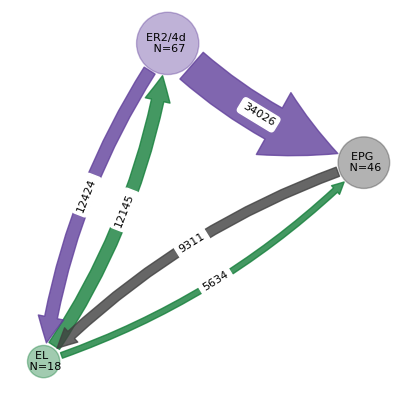

In [63]:
# plot the graph
k = 'weight'  # choose the edge attribute to visualize
pos = nx.spring_layout(graph, weight=k, seed=1)
# pos['ER2'] = pos['ER2'] + np.array([-.6, 0.1])  # adjust ER2 position for better visibility
# pos = nx.planar_layout(graph)
# pos['ER2/4d'] = [.5, .5]
# pos['EL'] = [.2,.2]
# pos['EPG']=[.8,.2]
# pos = nx.spectral_layout(graph, weight='relative_weight')
# pos['EL'] = pos['EL']+ np.array([.2, -0.1])  # adjust EL position for better visibility
fig, ax = plt.subplots(figsize=(5, 5))
nx.draw_networkx_nodes(graph, pos, node_size=[d['n_neurons']*30 for n, d in graph.nodes(data=True)], 
                       node_color=[colors[n] for n in graph.nodes()],
                       alpha=0.4, ax = ax)
nx.draw_networkx_labels(graph, pos, font_size=8, font_color='black', ax=ax,
                        labels={n: f"{n} \n N={d['n_neurons']}" for n, d in graph.nodes(data=True)})
nx.draw_networkx_edges(graph, pos, 
                    #    width=[d[k]*50 for u, v, d in graph.edges(data=True)],
                       connectionstyle='arc3,rad=0.12', edge_color=[colors[u] for u, v, d in graph.edges(data=True)],
                        node_size=[d['n_neurons']*30+200 for n, d in graph.nodes(data=True)],
                        ax=ax, 
                        arrowstyle=[f"simple, head_width={d[k]*.00015:.2f}, head_length={d[k]*.00015:.2f}, tail_width={d[k]*.000075:.2f}" for u, v, d in graph.edges(data=True)],
                        # arrowstyle=[f"simple, head_width={d[k]*.005:.2f}, head_length={d[k]*.005:.2f}, tail_width={d[k]*.002:.2f}" for u, v, d in graph.edges(data=True)],
                        # arrowstyle=[f"simple, head_width={d[k]*10:.2f}, head_length={d[k]*10:.2f}, tail_width={d[k]*5:.2f}" for u, v, d in graph.edges(data=True)],
                        alpha=.8)
_ = nx.draw_networkx_edge_labels(graph, pos, 
                               edge_labels={(u, v): f"{d[k]:.0f}" for u, v, d in graph.edges(data=True)},
                                font_size=8, connectionstyle='arc3,rad=0.12',
                  ax=ax)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig.savefig(figfolder / 'connectivity_graph.pdf')